# Optimal sensor placement using random forests and permutation importance

In [1]:
from os.path import join
import torch as pt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from flowtorch.data import mask_sphere
from scipy.stats import qmc
from scipy.spatial.distance import cdist

plt.rcParams["figure.dpi"] = 180
output = "./output"

## $Re=170$

In [2]:
case = "pinnball_re170"
x = pt.load(join(output, case, "x.pt"))
y = pt.load(join(output, case, "y.pt"))
t = pt.load(join(output, case, "snapshot_times.pt"))
p = pt.load(join(output, case, "p.pt"))
coeffs = pd.read_pickle(join(output, case, "coeffs.pkl"))

In [3]:
coeffs.describe()

,t,cx_a,cy_a,cz_a,cx_b,cy_b,cz_b,cx_c,cy_c,cz_c
count,136907.000000,136907.000000,136907.000000,1.369070e+05,136907.000000,136907.000000,1.369070e+05,136907.000000,136907.000000,1.369070e+05
mean,500.356666,0.372221,0.000191,-9.850997e-17,0.528670,0.001721,2.856944e-16,0.521222,0.000851,-1.822894e-16
std,288.923149,0.315521,0.007935,1.644792e-16,0.379540,0.057898,8.411838e-16,0.379585,0.055828,7.620321e-16
min,0.010000,0.300539,-0.023186,-1.044784e-16,0.453780,-13.524245,2.102230e-16,0.453634,-0.379155,-2.820338e-13
25%,249.863970,0.367204,-0.004859,-1.002766e-16,0.509175,-0.025581,2.678082e-16,0.497547,-0.021404,-1.931592e-16
50%,500.628570,0.371207,0.000218,-9.916344e-17,0.529396,0.003439,2.863808e-16,0.520342,0.001018,-1.811574e-16
75%,751.097825,0.374962,0.005446,-9.799221e-17,0.547281,0.029533,2.997497e-16,0.541054,0.023379,-1.669031e-16
max,1000.000000,117.054993,0.054073,6.075085e-14,140.501498,0.378905,3.113776e-13,140.490269,13.651089,-1.331034e-16


In [4]:
coeffs.head()

,t,cx_a,cy_a,cz_a,cx_b,cy_b,cz_b,cx_c,cy_c,cz_c
0,0.010000,117.054993,0.054073,6.075085e-14,140.501498,-13.524245,3.113776e-13,140.490269,13.651089,-2.820338e-13
1,0.017424,1.674146,-0.007360,2.618815e-16,2.434383,-0.422529,1.984022e-15,2.437429,0.404434,-1.805997e-15
2,0.024964,1.636067,-0.005192,7.310087e-17,2.071955,-0.382567,1.626829e-15,2.073692,0.369957,-1.462164e-15
3,0.032505,1.405250,-0.002371,3.943901e-17,1.790337,-0.336451,1.382082e-15,1.791259,0.330737,-1.226749e-15
4,0.040045,1.230751,-0.001077,2.344100e-17,1.587861,-0.302094,1.219563e-15,1.588369,0.299110,-1.068150e-15


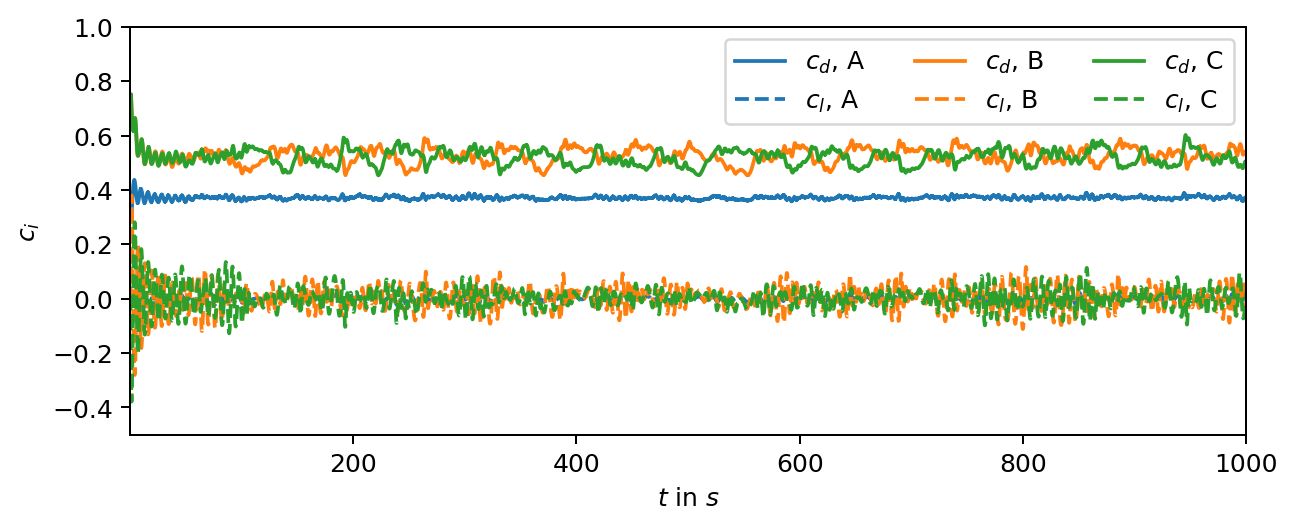

In [5]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(coeffs.t, coeffs.cx_a, ls="-", c="C0", label=r"$c_{d}$, A")
ax.plot(coeffs.t, coeffs.cy_a, ls="--", c="C0", label=r"$c_{l}$, A")
ax.plot(coeffs.t, coeffs.cx_b, ls="-", c="C1", label=r"$c_{d}$, B")
ax.plot(coeffs.t, coeffs.cy_b, ls="--", c="C1", label=r"$c_{l}$, B")
ax.plot(coeffs.t, coeffs.cx_c, ls="-", c="C2", label=r"$c_{d}$, C")
ax.plot(coeffs.t, coeffs.cy_c, ls="--", c="C2", label=r"$c_{l}$, C")
ax.set_xlabel(r"$t$ in $s$")
ax.set_ylabel(r"$c_i$")
ax.set_xlim(t.min(), t.max())
ax.set_ylim(-0.5, 1)
ax.legend(ncol=3)
plt.show()

The coefficients are sampled at a higher rate than the snapshots. Therefore, only timesteps of the coefficient data for which also snapshots are available are selected.

In [6]:
i_snapshots = []
for ti in t:
    i_snapshots.append((coeffs.t - ti.item()).abs().argmin())
i_snapshots = np.array(i_snapshots)

In [7]:
coeffs_reduced = coeffs.iloc[i_snapshots]

In [8]:
assert (pt.from_numpy(coeffs_reduced.t.values) - t).abs().sum() < 1e-8

### Baseline model

In [9]:
t_train_start, t_train_end = 200, 700
i_train_start, i_train_end = (t-t_train_start).abs().argmin(), (t-t_train_end).abs().argmin()
i_train_end - i_train_start

tensor(1000)

In [10]:
# we try to predict the drag and lift coefficients of all three cylinders
labels_train = coeffs_reduced[["cx_a", "cy_a", "cx_b", "cy_b", "cx_c", "cy_c"]].values[i_train_start.item():i_train_end.item(), :]
labels_test = coeffs_reduced[["cx_a", "cy_a", "cx_b", "cy_b", "cx_c", "cy_c"]].values[i_train_end.item():, :]
features_train = p[:, i_train_start:i_train_end].T.numpy()
features_test = p[:, i_train_end:].T.numpy()
labels_train.shape, labels_test.shape, features_train.shape, features_test.shape

((1000, 6), (601, 6), (1000, 27850), (601, 27850))

In [11]:
rf_params = {
    "bootstrap": True,
    "n_estimators": 100,
    "max_depth": 3,
    "max_features": "auto",
    "max_samples": 0.6,
    "min_samples_leaf": 4,
    "min_samples_split": 25,
    "n_jobs" : -1
}

In [12]:
every = 1
rf_model = RandomForestRegressor(**rf_params, random_state=0).fit(features_train[::every], labels_train[::every])

In [13]:
prediction_train = rf_model.predict(features_train)
prediction_test = rf_model.predict(features_test)

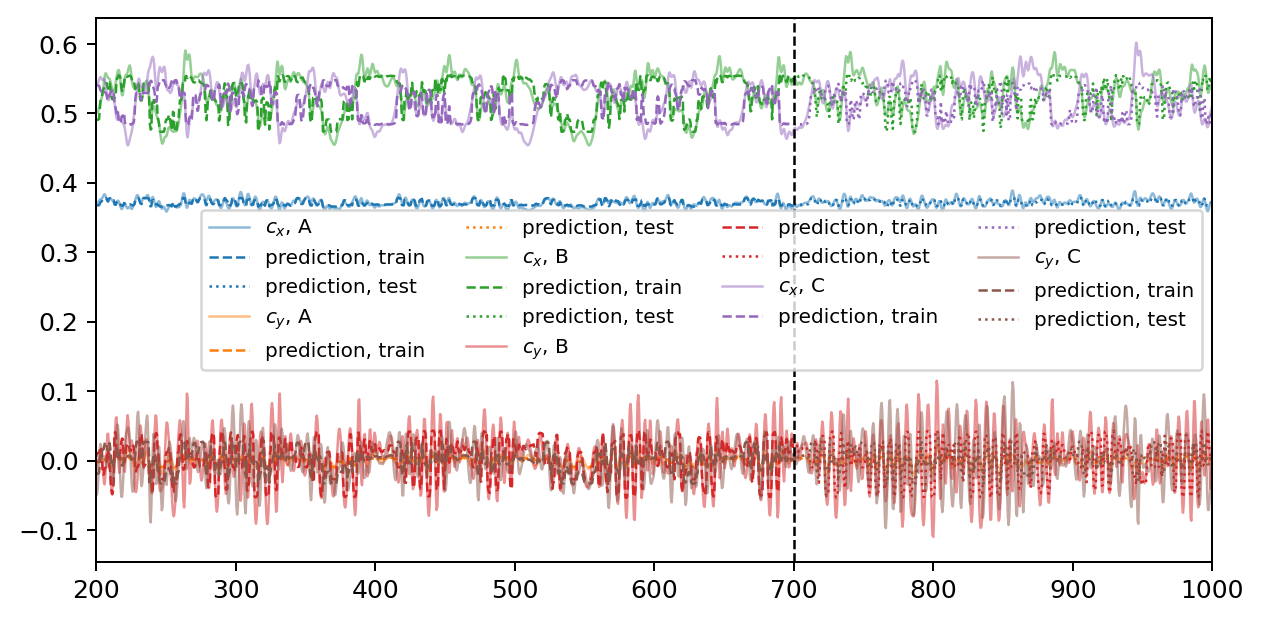

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
labels = [r"$c_x$, A", r"$c_y$, A", r"$c_x$, B", r"$c_y$, B", r"$c_x$, C", r"$c_y$, C"]
lw = 1
for li in range(labels_train.shape[1]):
    ax.plot(t[i_train_start:i_train_end], labels_train[:, li], c=f"C{li}", ls="-", lw=lw, label=labels[li], alpha=0.5)
    ax.plot(t[i_train_end:], labels_test[:, li], c=f"C{li}", ls="-", lw=lw, alpha=0.5)
    ax.plot(t[i_train_start:i_train_end], prediction_train[:, li], c=f"C{li}", ls="--", lw=lw, label="prediction, train")
    ax.plot(t[i_train_end:], prediction_test[:, li], c=f"C{li}", ls=":", lw=lw, label="prediction, test")
ax.legend(ncol=4, fontsize=8)
ax.set_xlim(t_train_start, t.max())
ax.axvline(t_train_end, ls="--", c="k", lw=1)
plt.show()

In [15]:
l2_train = np.square(labels_train - prediction_train).mean()
l2_test = np.square(labels_test - prediction_test).mean()
l2_train, l2_test

(0.0001717364125686018, 0.0002969537897277457)

### Sensor selection by feature importance and permutation importance

In [16]:
def lhs_masked(n_samples: int, lower: list, upper: list, seed: int) -> pt.Tensor:
    samples = qmc.LatinHypercube(d=2, seed=seed).random(n_samples)
    samples = pt.from_numpy(qmc.scale(samples, lower, upper))
    mask_a = pt.logical_not(mask_sphere(samples, (-1.299, 0.0), 0.5))
    mask_b = pt.logical_not(mask_sphere(samples, (0.0, 0.75), 0.5))
    mask_c = pt.logical_not(mask_sphere(samples, (0.0, -0.75), 0.5))
    mask = pt.logical_and(pt.logical_and(mask_a, mask_b), mask_c)
    sub_samples = pt.zeros((mask.sum().item(), 2))
    sub_samples[:, 0] = samples[mask, 0]
    sub_samples[:, 1] = samples[mask, 1]
    return sub_samples

In [17]:
# how many times to sample
n_repeat = 10
# how many x-y-samples to draw
n_samples = 100
# n most important features to keep
n_keep = 20
# number of permutations
n_perm = 10

importance_rf, selected_rf = [], []
importance_pi, selected_pi = [], []

for i in range(n_repeat):
    print(f"\rStarting run {i+1}", end="")
    # LHS of points
    samples = lhs_masked(n_samples, [-2.5, -2.0], [10.0, 2.0], i)
    # map to closest grid points
    selected = cdist(samples, pt.stack((x, y)).T.numpy(), metric="sqeuclidean").argmin(axis=1)
    # train RF and record importance
    model = RandomForestRegressor(**rf_params, random_state=i).fit(features_train[:, selected], labels_train)
    imp_ft = model.feature_importances_.argsort()[-n_keep:][::-1]
    importance_rf.append(model.feature_importances_[imp_ft])
    selected_rf.append(selected[imp_ft])
    # measure permutation importance
    imp_perm = permutation_importance(model, features_test[:, selected], labels_test, n_jobs=-1, n_repeats=n_perm, random_state=i)
    top_n = imp_perm["importances_mean"].argsort()[-n_keep:][::-1]
    importance_pi.append(imp_perm["importances_mean"][top_n])
    selected_pi.append(selected[top_n])

Starting run 10

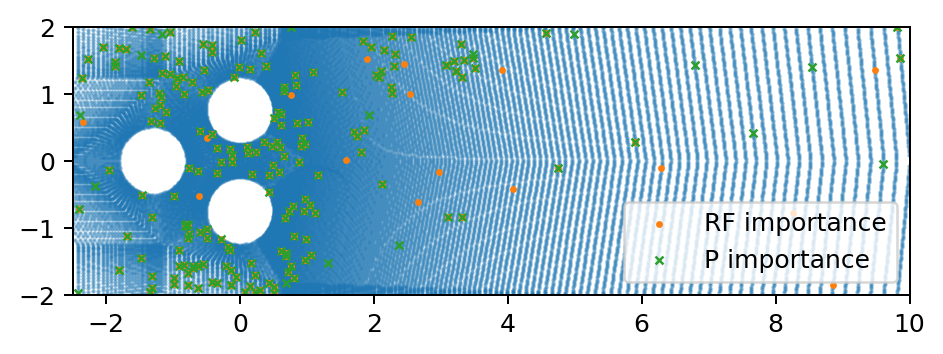

In [18]:
plt.scatter(x, y, s=0.5, alpha=0.5)
plt.scatter(x[np.concatenate(selected_rf)], y[np.concatenate(selected_rf)], s=3, label="RF importance")
plt.scatter(x[np.concatenate(selected_pi)], y[np.concatenate(selected_pi)], s=10, marker="x", lw=1, label="P importance")
plt.gca().set_aspect("equal")
plt.xlim(-2.5, 10)
plt.ylim(-2, 2)
plt.legend()
plt.show()

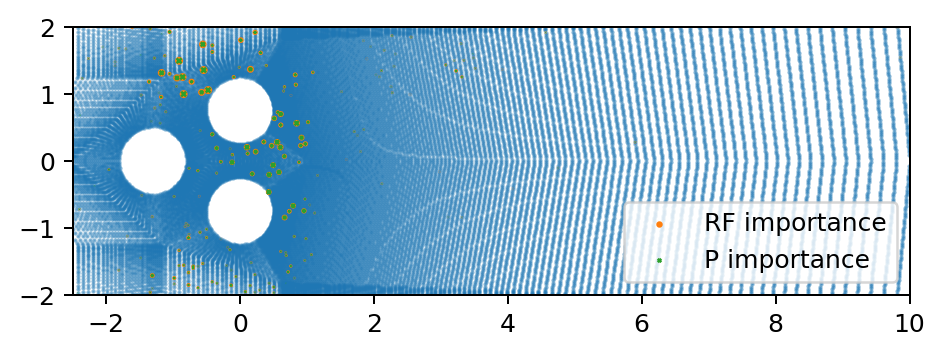

In [19]:
# scaled with importance
plt.scatter(x, y, s=0.5, alpha=0.5)
plt.scatter(x[np.concatenate(selected_rf)], y[np.concatenate(selected_rf)], s=np.concatenate(importance_rf)*10, label="RF importance")
plt.scatter(x[np.concatenate(selected_pi)], y[np.concatenate(selected_pi)], s=np.concatenate(importance_pi)*10, marker="x", lw=1, label="P importance")
plt.gca().set_aspect("equal")
plt.xlim(-2.5, 10)
plt.ylim(-2, 2)
plt.legend()
plt.show()

In [20]:
# test prediction with results from 1st run
final_model = RandomForestRegressor(**rf_params, random_state=0).fit(features_train[:, selected_rf[0]], labels_train)
prediction_train = final_model.predict(features_train[:, selected_rf[0]])
prediction_test = final_model.predict(features_test[:, selected_rf[0]])

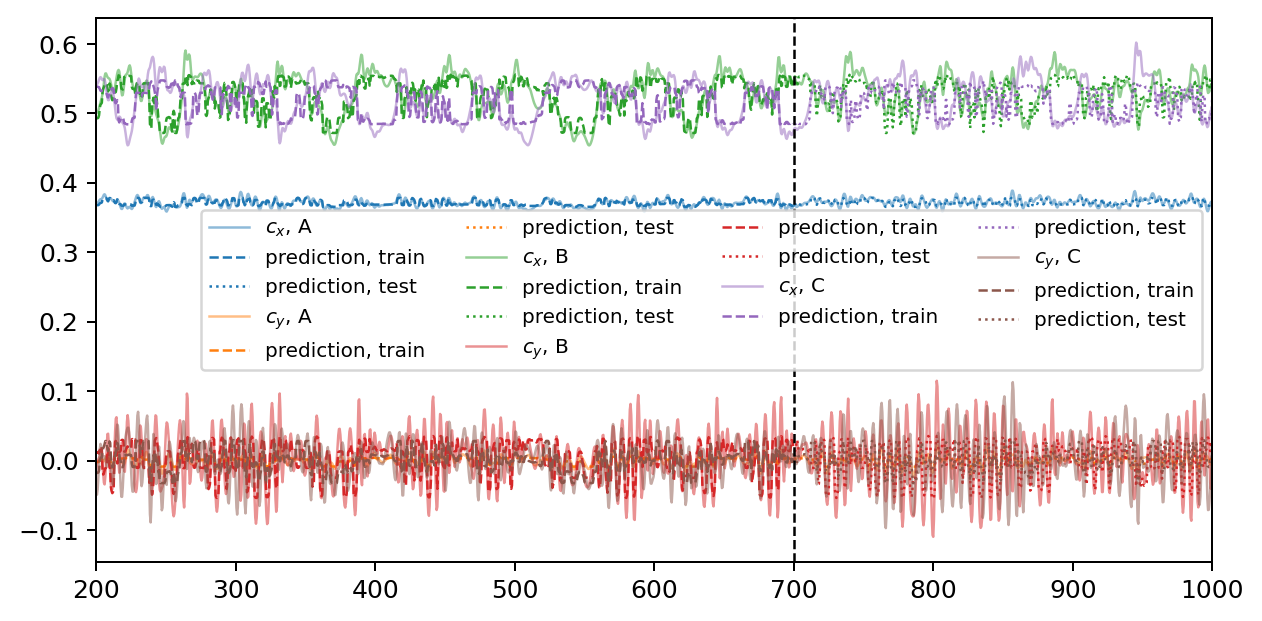

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
labels = [r"$c_x$, A", r"$c_y$, A", r"$c_x$, B", r"$c_y$, B", r"$c_x$, C", r"$c_y$, C"]
lw = 1
for li in range(labels_train.shape[1]):
    ax.plot(t[i_train_start:i_train_end], labels_train[:, li], c=f"C{li}", ls="-", lw=lw, label=labels[li], alpha=0.5)
    ax.plot(t[i_train_end:], labels_test[:, li], c=f"C{li}", ls="-", lw=lw, alpha=0.5)
    ax.plot(t[i_train_start:i_train_end], prediction_train[:, li], c=f"C{li}", ls="--", lw=lw, label="prediction, train")
    ax.plot(t[i_train_end:], prediction_test[:, li], c=f"C{li}", ls=":", lw=lw, label="prediction, test")
ax.legend(ncol=4, fontsize=8)
ax.set_xlim(t_train_start, t.max())
ax.axvline(t_train_end, ls="--", c="k", lw=1)
plt.show()

In [22]:
l2_train = np.square(labels_train - prediction_train).mean()
l2_test = np.square(labels_test - prediction_test).mean()
l2_train, l2_test

(0.00019610919747843966, 0.000328744486426687)